In [1]:
# https://people.sc.fsu.edu/~jburkardt/data/ply/ply.html
# https://stackoverflow.com/questions/50965673/python-display-3d-point-cloud
%matplotlib inline
import numpy as np
import open3d as o3d
import numpy.matlib
import scipy
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
pixelSize = 2e-03 # Approximation for a common pixel size of a camera in mm (2um -actually)

# Estimated Camera Parameters of a Huawei Y5-2017 Phone's Back Camera
alpha_x, alpha_y  = [x*pixelSize for x in [ 2700.1129,  2704.0118 ]] # focal Length in pixels
beta_x , beta_y   = [x*pixelSize for x in [ 1179.3009,  1588.6612 ]] # principal Pointin pixels
# radialDistortion = [    0.0926,    -0.2114 ]

#Calculating Intrinsic Matrix K
IntrinsicMatrix = np.array([
    [alpha_x, 0      , beta_x],
    [0      , alpha_y, beta_y],
    [0      ,0       , 1     ]
]) 

In [3]:
# in rad
rotationVectors  = np.array([
 [    0.1588,   0.0631,  1.5096],
 [   -0.2234,   0.4752,  1.5148],
 [    0.2675,   0.7273,  1.5628],
 [   -0.5501,  -0.0713,  1.3859],
 [    0.5973,  -0.3509,  1.4462],
 [    0.7129,   0.5485,  1.4374],
 [   -0.3825,  -0.5195,  1.4603],
 [    0.5176,  -0.3308,  1.5007],
 [    0.0257,  -0.4419, -0.0002],
 [    0.0536,   0.7438, -0.0341],
 [   -0.1150,   0.4484,  1.5657],
 [   -0.4369,  -0.3818,  1.4392],
 [    0.7449,   0.5763,  1.4086],
 [    0.0326,  -0.6226,  1.5766],
 [    0.1588,  -0.0428,  1.5457],
 [   -0.2892,   0.4623,  1.5130],
 [    0.0113,   0.7785,  0.0270],
 [    0.3784,  -0.4751,  0.0885],
 [    0.3874,   0.7383, -0.1240],
 [   -0.8528,   0.1070, -0.0451]])

# in mm
translationVectors = np.array([
 [  155.9579, -149.0883,  504.5399 ],
 [  176.5537, -123.4080,  639.8593 ],
 [  180.8317, -134.0703,  507.8285 ],
 [   84.0470, -136.3349,  669.0573 ],
 [  119.6632,  -95.3260,  384.8297 ],
 [   82.4593, -132.8647,  290.4283 ],
 [  122.0913, -142.2950,  429.6691 ],
 [  122.5745, -161.9149,  367.3551 ],
 [ -103.7371, -130.3420,  402.5284 ],
 [  -66.6782,  -95.1525,  530.3091 ],
 [  152.3982, -125.6566,  615.8554 ],
 [  106.9474, -141.9626,  515.0723 ],
 [   76.2934, -131.5001,  327.6164 ],
 [  163.2290, -122.9659,  484.1596 ],
 [  123.0242, -136.7787,  453.6079 ],
 [  121.1290, -172.0656,  520.5429 ],
 [  -56.3611,  -82.7235,  537.3520 ],
 [  -51.0117,  -97.1251,  355.1822 ],
 [ -125.1265, -110.6333,  418.3420 ],
 [ -112.7127,  -53.8583,  577.6856 ]])

In [4]:
# Constructing the 
def getExtrinsicMatrix(rotationVector, translationVector):
    """
    Calculating Extrinsic Matrix [R|t]x4
    using 3D Rotation matrix and Translation Matrix
    """
    theta_1, theta_2, theta_3 = rotationVector   
    rotate_X = np.array([ # Rotation abot x axis
      [1,  0              ,  0               ,   0 ],
      [0,  np.cos(theta_1),  -np.sin(theta_1),   0 ],
      [0,  np.sin(theta_1),   np.cos(theta_1),   0 ],
      [0,  0              ,  0               ,   1 ]
    ])

    rotate_Y = np.array([ # Rotation abot y axis    
      [ np.cos(theta_2) , 0 , np.sin(theta_2)  , 0 ],
      [0                , 1 , 0                , 0 ],
      [-np.sin(theta_2) , 0 , np.cos(theta_2)  , 0 ],
      [0                , 0 , 0                , 1 ]
    ])


    rotate_Z = np.array([ # Rotation abot z axis
      [np.cos(theta_3) , -np.sin(theta_3), 0  ,  0 ],
      [np.sin(theta_3) ,  np.cos(theta_3), 0  ,  0 ],
      [0               ,  0              , 1  ,  0 ],
      [0               ,  0              , 0  ,  1 ]
    ])
    
    rotationMatrix   = rotate_X.dot(rotate_Y).dot(rotate_Z)
    
    translatioMatrix = np.eye(4) # last column can be replaced by the translation vector
    translatioMatrix[:-1,-1] = translationVector    
    ExtrinsicMatrix = rotationMatrix.dot(translatioMatrix)
    
    return np.array(ExtrinsicMatrix[:-1,:]) # First three rows only to make it 3x4

PointCloud with 2903 points.


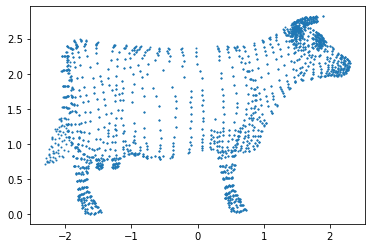

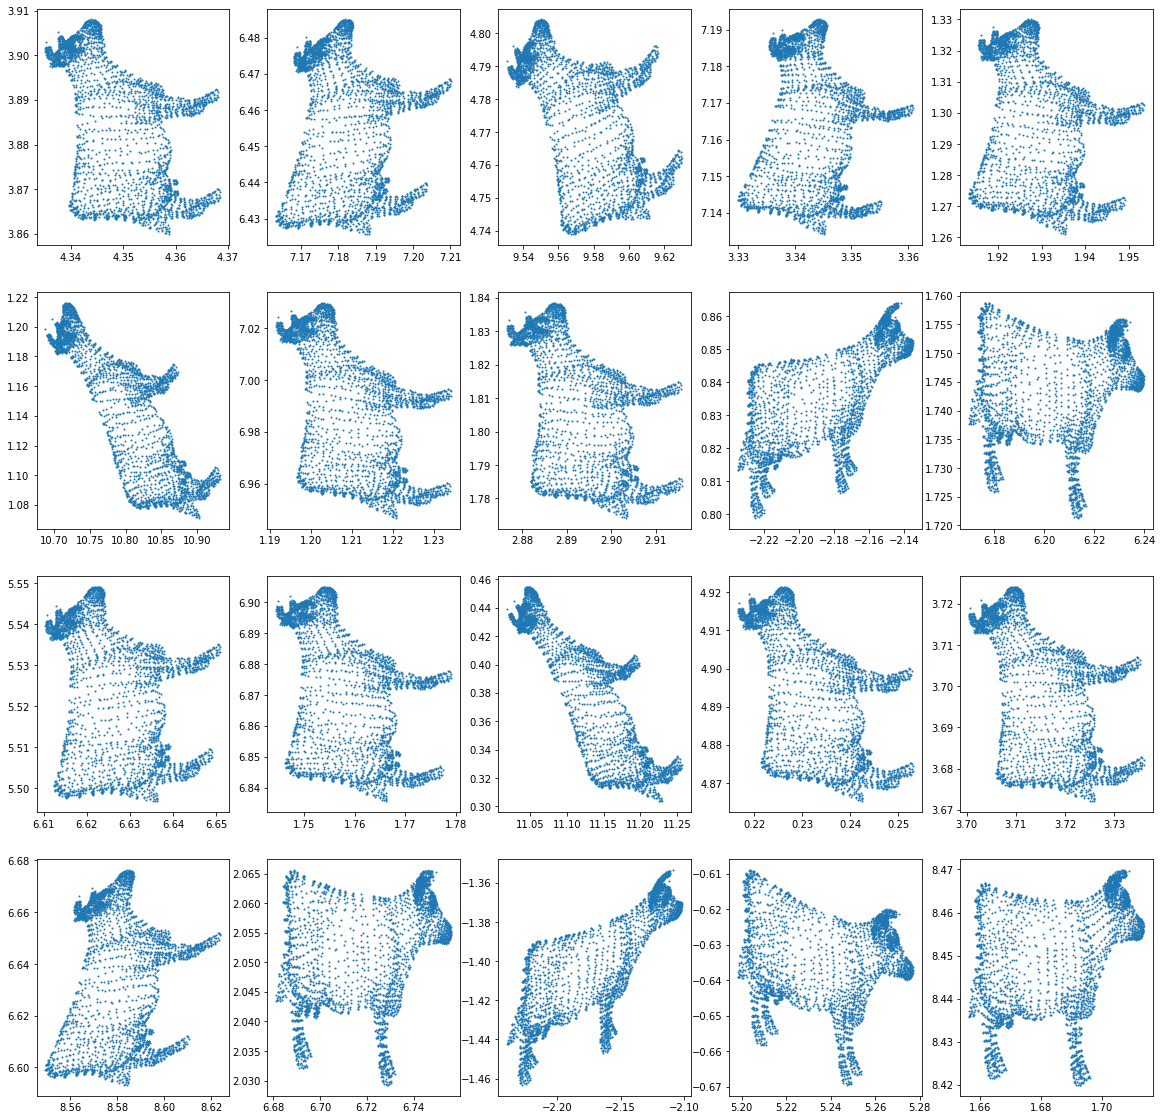

In [5]:
pcd = o3d.io.read_point_cloud("../Point cloud Related/pointClouds/"+"cow.ply") # Read the point cloud
print(pcd)
#o3d.visualization.draw_geometries([pcd])
points = np.asarray(pcd.points)
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1],s=1)
ones = np.ones((points.shape[0], 1))
points = np.concatenate((points, ones), axis=1) # Making the points homogeneous

fig, ax = plt.subplots(4,5, figsize=(20,20))
location = 1
for i in range(20):   
    ExtrinsicMatrix = getExtrinsicMatrix(rotationVectors[i],translationVectors[i])
    CameraMatrix    =  IntrinsicMatrix.dot(ExtrinsicMatrix)
    P1 = CameraMatrix
    transfromed = np.matmul(P1, points.T).T
    transfromed = transfromed/np.matlib.repmat(transfromed[:,2], 3, 1).T # devide by the last coordinate
    
    plt.subplot(4,5,location)
    plt.scatter(transfromed[:,0], transfromed[:,1],s=1)
    location+=1